### Load packages etc, and load the child-class of gmspython, "Abatement", and load "techdata_to_tree" which converts a technology catalog into production trees

In [1]:
clean_up=True # removes gams-related files in work-folder if true
%run StdPackages.ipynb
os.chdir(py['main'])
import abatement, sys, ShockFunction
os.chdir(curr)
data_folder = os.getcwd()+'\\Data'
gams_folder = data_folder + "\\..\\gamsmodels\\Main"
# from mpl_toolkits.axisartist.axislines import AxesZero
from matplotlib.ticker import NullFormatter
# pickle_path = 

The file_gams_py_gdb0.gdx is still active and was not deleted.
The file_gams_py_gdb1.gdx is still active and was not deleted.
The file_gams_py_gdb3.gdx is still active and was not deleted.


In [2]:
m = abatement.abate(pickle_path=gams_folder+"/gmspython_Abatement", work_folder=work_folder)
m.model.functions = {"std_pdf":"$FUNCTION std_pdf({x}): ((1/(sqrt(2*Pi)))*exp(-(Sqr({x}))/2)) $ENDFUNCTION"}

In [3]:
m.setstate("EOP")
m.reset_settings()

## A rising price of emissions (oil)
We present graphically what happens when the oil price gradually increases (static model solution for each price).
For this, we again use the sneaky solve, but we make sure to extract variables of interest for each iteration, in contrast to above where we were not interested in the solutions per se, but simply that the values of $\sigma$ ended in the desired spots.

In [4]:
#mideleritid start fra starten
#m.model.settings.databases["Abatement_0"]["sigma"].vals.loc[:] = 0.1
#m.model.settings.databases["Abatement_0"]["eta"].vals.loc[:] = -0.1

In [5]:
# m.write_and_run(name="calibrated", add_checkpoint="calibrated")

In [6]:
m.write_and_run(name="CO2tax")
out_db = m.model_instances["CO2tax"].out_db

In [7]:
m.write_and_run(name='CO2tax', add_checkpoint='CO2tax_cp', overwrite=True)
mi = m.model_instances['CO2tax']

*2: Define structure of shock* 

In [8]:
db_end_of_loop = DataBase.GPM_database()

In [9]:
db_end_of_loop["pM"] = m.model_instances["CO2tax"].out_db.get("pM") + 7.5

In [10]:
#NY ME DDIREKTE
#m.model_instances["oilshock"].solve_sneakily(db_star=db_end_of_loop, from_cp=True, cp_init=m.checkpoints["calibrated"])

In [11]:
(shock_db, shock_kwargs) = ShockFunction.sneaky_db(out_db, db_end_of_loop, n_steps = 40, loop_name='CO2tax_loop')

*3: Define the solution we wish to store for each iteration (conditions argument is optional, but here we extract only the production sector goods):*

In [12]:
shock_db.series["pM_CO2tax_loop"].vals.head()

n    CO2tax_loop  
CO2  CO2tax_loop_1    5.000000
     CO2tax_loop_2    5.192308
     CO2tax_loop_3    5.384615
     CO2tax_loop_4    5.576923
     CO2tax_loop_5    5.769231
Name: pM_CO2tax_loop, dtype: float64

In [13]:
store_sol = {'M': {'domains': shock_kwargs['loop_name']}, "M0":{'domains': shock_kwargs['loop_name']}, 
             "pM":{'domains': shock_kwargs['loop_name']}, "qsumX":{'domains': shock_kwargs['loop_name']},
             "PwThat":{'domains': shock_kwargs['loop_name']}}

*4: Create Shock instance*

In [14]:
shock = mi.std_UEVAS_from_db(shock_db, loop_name=shock_kwargs['loop_name'], shock_name=shock_kwargs['shock_name'], store_sol=store_sol)
#shock = mi.std_UEVAS_from_db(shock_db, loop_name=shock_kwargs['loop_name'], shock_name=shock_kwargs['shock_name'])
#solve_sneakily skal have selve checkpointet
#Gør noget så sneaky solve laver et sidste checkpoint

*5: Execute shock from the 'calibrated' checkpoint i.e. the model state after the sigmas have been chosen:*

In [15]:
mi.execute_shock_from_cp(shock=shock, cp=m.checkpoints['CO2tax_cp'])

In [16]:
sols = {"M0":mi.out_db.series["sol_M0"].vals, "M":mi.out_db.series["sol_M"].vals, "pM":mi.out_db.series["sol_pM"].vals}

In [36]:
df = pd.DataFrame(sols).drop(columns="M0")

In [20]:
oilprice = mi.out_db.series["sol_PwThat"].vals.reset_index()

In [21]:
df["effective_oil_price"] = oilprice[oilprice["n"].apply(lambda x: "oil" in x)].groupby("CO2tax_loop", sort=False)["sol_PwThat"].max().values

In [23]:
oil = mi.out_db.series["sol_qsumX"].vals.reset_index()

In [24]:
df["oil"] = oil[oil["n"].apply(lambda x: "oil" in x)].groupby("CO2tax_loop", sort=False)["sol_qsumX"].sum().values

In [25]:
df.set_index("pM", inplace=True)

In [26]:
def translate(col):    
    translate = {
        "M":"Emissions",
        "pM":"Price of emissions",
        "effective_oil_price":"Effective oil price",
        "oil":"Oil use"
    }
    if col in translate:
        return translate[col]
    else:
        return col

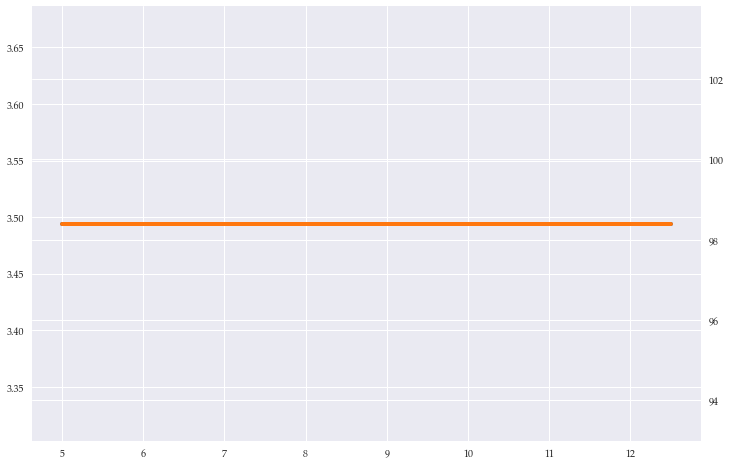

In [27]:
#First figure, with oil price and oil usage
fig = plt.figure(figsize=(12, 8))
fig.add_subplot(1, 1, 1)
ax = fig.get_axes()[0]
col = "effective_oil_price" 
ax.plot(df.index, col, data=df, label=translate(col), linewidth=4, color="#1f77b4")
ax2 = ax.twinx()
col = "oil"
ax2.plot(df.index, col, data=df, label=translate(col), linewidth=4, color="#ff770e")
#

In [26]:
lines, labels = ax.get_legend_handles_labels()
lines = lines + ax2.get_legend_handles_labels()[0]
labels = labels + ax2.get_legend_handles_labels()[1]

In [27]:
ax.legend(lines, labels, fontsize=16, loc="right")

In [28]:
ax2.vlines(x=[6.5, 10], ymin=df[col].min(), ymax=df[col].max(), ls='--', color="grey", lw=2)

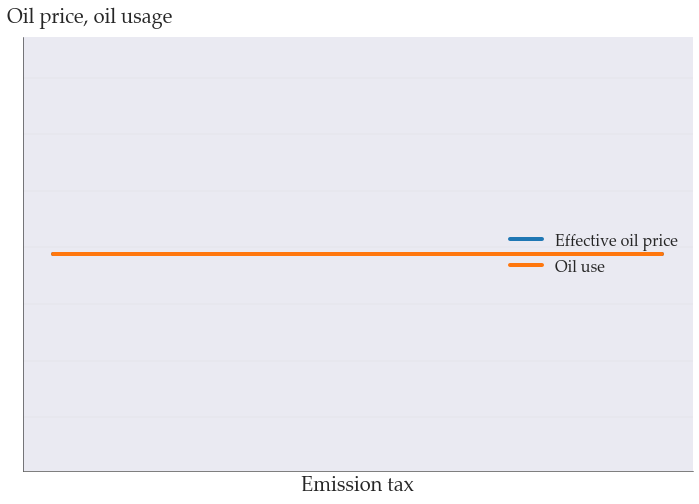

In [29]:
ax.set_xlabel("Emission tax", fontsize=20)
ax.set_ylabel("Oil price, oil usage", fontsize=20, rotation=0)
ax.yaxis.set_label_coords(0.1,1.02)
ax.get_xaxis().set_ticks([])
ax2.get_yaxis().set_ticks([])
# ax.get_yaxis().set_ticks([])
ax.spines["left"].set_visible(True)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_linewidth(0.5)
ax.spines["left"].set_edgecolor("k")
ax.spines["bottom"].set_edgecolor("k")
ax.spines["bottom"].set_linewidth(0.5)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax2.grid(False)
#ax.set_axisbelow(True)
ax.grid(axis='y', color="lightgrey", linewidth=0.2)
ax.get_yaxis().set_major_formatter(NullFormatter())


fig

In [30]:
fig.savefig("oilprice_oilusage.pdf", bbox_inches="tight", transparent=True)

Figure number 2, electricity

In [31]:
elec = mi.out_db.series["sol_qsumX"].vals.reset_index()

In [32]:
df["electricity"] = elec[elec["n"].apply(lambda x: "electricity" in x)].groupby("CO2tax_loop", sort=False)["sol_qsumX"].sum().values

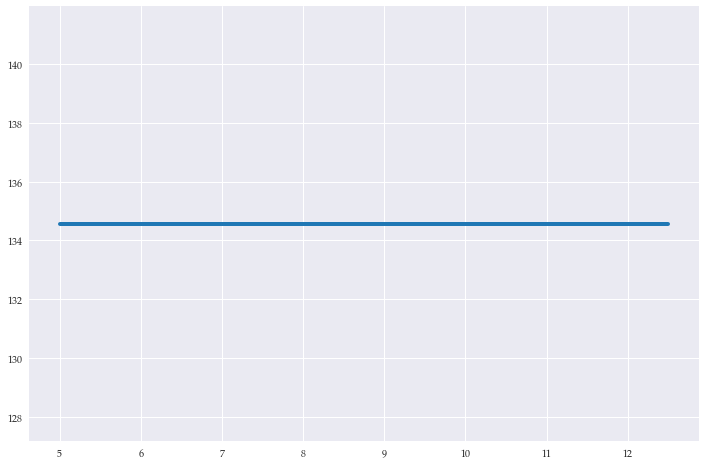

In [33]:
fig2 = plt.figure(figsize=(12, 8))
fig2.add_subplot(1, 1, 1)
ax_elec = fig2.get_axes()[0]
col = "electricity" 
ax_elec.plot(df.index, col, data=df, label=translate(col), linewidth=4, color="#1f77b4")
ax_elec.vlines(x=[6.5, 10], ymin=df[col].min(), ymax=df[col].max(), ls='--', color="grey", lw=2)
#

In [34]:
def format_single_axis(axes, x_label="", y_label=""):
    axes.set_xlabel(x_label, fontsize=20)
    axes.set_ylabel(y_label, fontsize=20, rotation=0)
    axes.yaxis.set_label_coords(0.1,1.02)
    axes.get_xaxis().set_ticks([])
#     axes.get_yaxis().set_ticks([])
    axes.spines["left"].set_visible(True)
    axes.spines["bottom"].set_visible(True)
    axes.spines["left"].set_linewidth(0.5)
    axes.spines["left"].set_edgecolor("k")
    axes.spines["bottom"].set_edgecolor("k")
    axes.spines["bottom"].set_linewidth(0.5)
    axes.spines["right"].set_visible(False)
    axes.spines["top"].set_visible(False)
    #axes.set_axisbelow(True)
    axes.grid(axis='y', color="lightgrey", linewidth=0.2)
    axes.get_yaxis().set_major_formatter(NullFormatter())

In [35]:
format_single_axis(ax_elec, x_label="Emission price", y_label="Electricity use")


In [36]:
fig2.savefig("electricity_use.pdf", bbox_inches="tight", transparent=True)

C:\Users\zgr679\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  
C:\Users\zgr679\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: Second argument 'M' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.
  


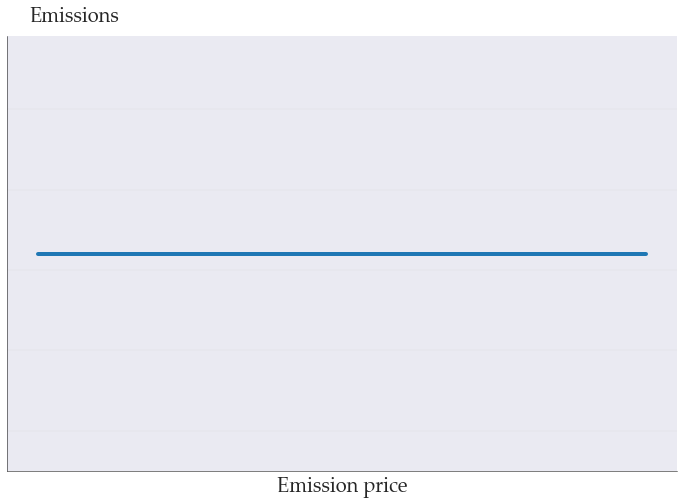

In [37]:
#THIRD PLOT, OF EMISSIONS
fig3 = plt.figure(figsize=(12, 8))
fig3.add_subplot(1, 1, 1)
ax4 = fig3.get_axes()[0]
col = "M" 
ax4.plot(df.index, col, data=df, label=translate(col), linewidth=4, color="#1f77b4")
ax4.vlines(x=[6.5, 10], ymin=df[col].min(), ymax=df[col].max(), ls='--', color="grey", lw=2)
format_single_axis(ax4, x_label="Emission price", y_label=translate(col))




In [38]:
fig3.savefig("Emissions.pdf", bbox_inches="tight", transparent=True, facecolor="none", edgecolor='none')